In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Verileri düzenlemek ve eğitmek iin gerekli kütüphaneleri import ediyoruz.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer,accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier

Datasetimizin bulunduğu path'i yazıyoruz.

In [4]:
file_path = '/kaggle/input/bitcoin-historical-datasets-2018-2024/btc_1h_data_2018_to_2024-09-06.csv' # günlük verileri çekmek istiyorum
data = pd.read_csv(file_path)


Datamızın ilk 5 satırını yazdırıyoruz. 

In [5]:
data.head()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,2018-01-01 00:00:00,13715.65,13715.65,13400.01,13529.01,443.356199,2018-01-01 00:59:59.999,5.993910e+06,5228,228.521921,3.090541e+06,0
1,2018-01-01 01:00:00,13528.99,13595.89,13155.38,13203.06,383.697006,2018-01-01 01:59:59.999,5.154522e+06,4534,180.840403,2.430449e+06,0
2,2018-01-01 02:00:00,13203.00,13418.43,13200.00,13330.18,429.064572,2018-01-01 02:59:59.999,5.710192e+06,4887,192.237935,2.558505e+06,0
3,2018-01-01 03:00:00,13330.26,13611.27,13290.00,13410.03,420.087030,2018-01-01 03:59:59.999,5.657448e+06,4789,137.918407,1.858041e+06,0
4,2018-01-01 04:00:00,13434.98,13623.29,13322.15,13601.01,340.807329,2018-01-01 04:59:59.999,4.588047e+06,4563,172.957635,2.328058e+06,0


Datamızda kaç satır, kaç sütun olduğunu kontrol ediyoruz.

In [6]:
data.shape

(58454, 12)

Datamızdaki sütun isimlerini yazdırıyoruz.

In [7]:
data.columns

Index(['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
       'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Ignore'],
      dtype='object')

Data hakkında bilgi alıyoruz.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58454 entries, 0 to 58453
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Open time                     58454 non-null  object 
 1   Open                          58454 non-null  float64
 2   High                          58454 non-null  float64
 3   Low                           58454 non-null  float64
 4   Close                         58454 non-null  float64
 5   Volume                        58454 non-null  float64
 6   Close time                    58454 non-null  object 
 7   Quote asset volume            58454 non-null  float64
 8   Number of trades              58454 non-null  int64  
 9   Taker buy base asset volume   58454 non-null  float64
 10  Taker buy quote asset volume  58454 non-null  float64
 11  Ignore                        58454 non-null  int64  
dtypes: float64(8), int64(2), object(2)
memory usage: 5.4+ MB


Matplotlib kütüphanesini kullanarak datamızın Close adlı sütunundan veri çekerek "Bitcoin kapanış fiyatlarının dağılımı" adlı tabloyu oluşturuyoruz.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


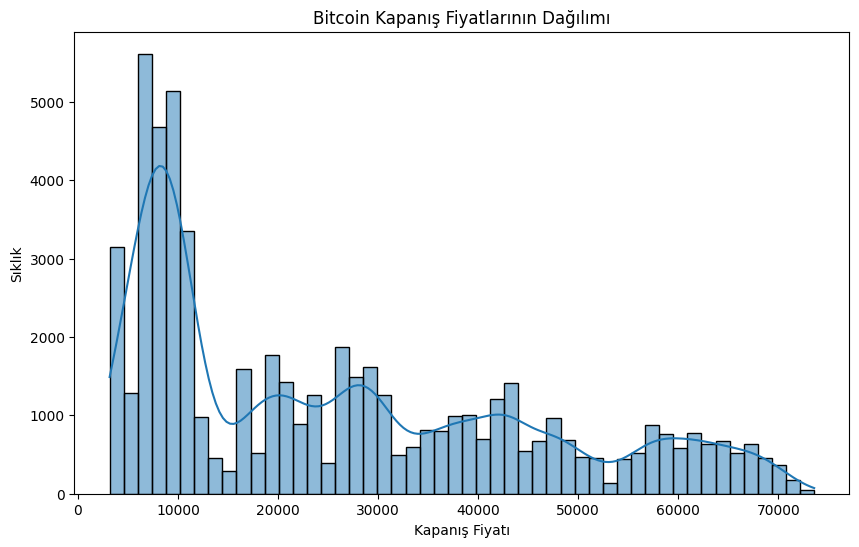

In [9]:
plt.figure(figsize=(10,6))
sns.histplot(data['Close'], bins=50, kde=True)
plt.title('Bitcoin Kapanış Fiyatlarının Dağılımı')
plt.xlabel('Kapanış Fiyatı')
plt.ylabel('Sıklık')
plt.show()

Matplotlib kütüphanesini kullanarak datamızın Open time adlı sütunu ile Close adlı sütunundan veri çekerek "Kapanış fiyatlarının zaman içinde değişimi" adlı tabloyu oluşturuyoruz.

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(data['Open time'][:50000:100], data['Close'][:50000:100])
plt.title('Kapanış Fiyatlarının Zaman İçinde Değişimi (İlk 5000 veri için)')
plt.xlabel('Zaman')
plt.ylabel('Kapanış Fiyatı')
plt.show()

Seaborn kütüphanesini kullanarak verinin korelasyon ısı haritasını çıkarıyoruz. Open time ve Close time sütunları veri tipi string olarak geçtiği için onları dataframeden çıkarıyoruz.

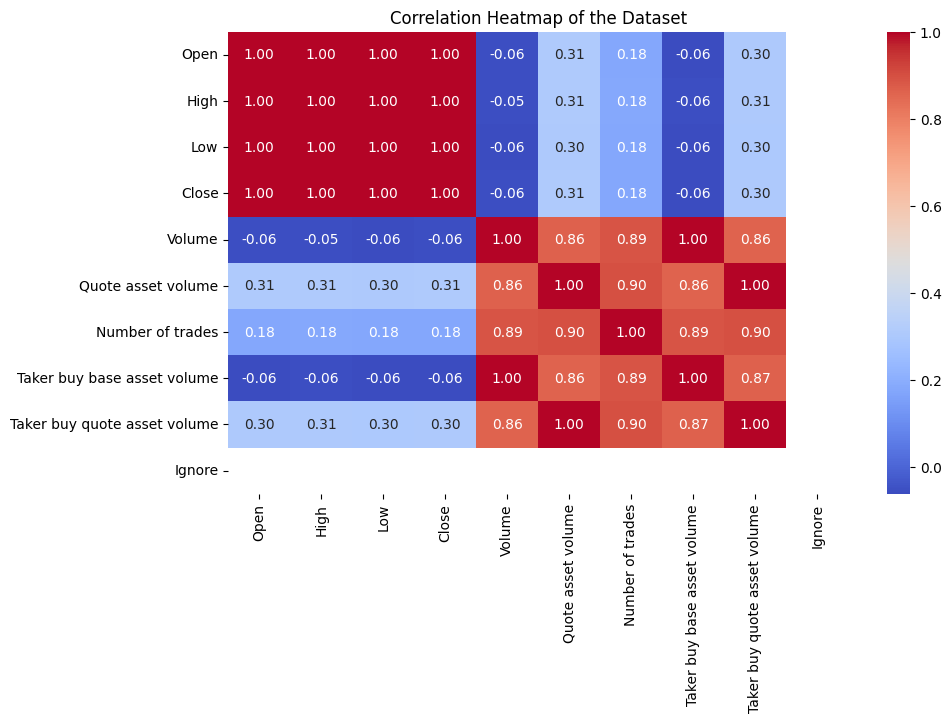

In [11]:
plt.figure(figsize=(10,6))
data_try=data.drop(columns=["Open time","Close time"])
correlation_matrix = data_try.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of the Dataset')
plt.show()

İşimize yaramayacak sütunları siliyoruz.

In [12]:
data_cleaned = data.drop(columns=['Open time', 'Close time', 'Ignore'])

Veriyi min-miax normalizasyonunu kullanarak veriyi normalize ediyoruz.

In [13]:
scaler = MinMaxScaler()
numeric_cols = data_cleaned.columns
data_scaled = pd.DataFrame(scaler.fit_transform(data_cleaned), columns=numeric_cols)

Burada Close sütununu diğer bağımsız sütunlardan ayırarak eğitime tabi tutmak için hazırlıyoruz.

In [14]:
X = data_scaled.drop(columns=['Close'])
y = data_scaled['Close']

burada veriyi train ve test olarak ayırıyoruz.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verinin boyutlarını kontrol etme
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (46763, 8), X_test shape: (11691, 8)
y_train shape: (46763,), y_test shape: (11691,)


In [16]:
data_scaled.head()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
0,0.149749,0.149179,0.146216,0.147105,0.003231,0.001994,0.003625,0.003331,0.002056
1,0.147098,0.147483,0.142725,0.142475,0.002796,0.001715,0.003144,0.002636,0.001617
2,0.142467,0.144969,0.143361,0.144281,0.003127,0.001900,0.003389,0.002802,0.001702
3,0.144275,0.147701,0.144646,0.145415,0.003062,0.001882,0.003321,0.002010,0.001236
4,0.145762,0.147871,0.145105,0.148127,0.002484,0.001526,0.003164,0.002521,0.001549


Lineer regresyon kullanarak veriyi eğitiyoruz.

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

#Tahminlerin yapılması
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Modelin değerlendirilmesi (MSE, R2 Skoru)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

#Sonuçların yazdırılması
print(f"Training Set MSE: {mse_train}")
print(f"Test Set MSE: {mse_test}")
print(f"Training Set R^2: {r2_train}")
print(f"Test Set R^2: {r2_test}")

#10 test tahmini ve gerçek değerlerin yazdırılması
print("\n10 Veri (Test Set):")
print(f"Tahminler: {y_pred_test[70:80]}")
print(f"Gerçekler: {y_test[70:80].values}")

In [18]:

data_scaled['Close_category'] = pd.qcut(data_scaled['Close'], q=3, labels=[0, 1, 2])

# Özellikler ve hedef değişkenin ayrılması
X = data_scaled.drop(columns=['Close', 'Close_category'])
y = data_scaled['Close_category']

# 6. Veri setini eğitim ve test kümelerine ayırma (80% eğitim, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Decision Tree Classifier modelini tanımlama ve eğitme
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# 8. Tahminlerin yapılması
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# 9. Modelin değerlendirilmesi (Doğruluk ve sınıflandırma raporu)
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
classification_rep = classification_report(y_test, y_pred_test)

# 10. Sonuçların yazdırılması
print(f"Training Set Accuracy: {train_accuracy}")
print(f"Test Set Accuracy: {test_accuracy}")
print("\nClassification Report (Test Set):")
print(classification_rep)

#10 test tahmini ve gerçek değerlerin yazdırılması
print("\n10 Veri (Test Set):")
print(f"Predictions: {y_pred_test[100:110]}")
print(f"Actuals: {y_test[100:110].values}")

Training Set Accuracy: 1.0
Test Set Accuracy: 0.9973483876486186

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3881
           1       1.00      1.00      1.00      3871
           2       1.00      1.00      1.00      3939

    accuracy                           1.00     11691
   macro avg       1.00      1.00      1.00     11691
weighted avg       1.00      1.00      1.00     11691


First 10 Predictions vs Actuals (Test Set):
Predictions: [2 1 2 0 0 0 2 1 1 1]
Actuals: [2, 1, 2, 0, 0, 0, 2, 1, 1, 1]
Categories (3, int64): [0 < 1 < 2]


In [19]:
from sklearn.cluster import KMeans

In [20]:
data_cleaned = data.drop(columns=['Open time', 'Close time', 'Ignore'])

#Normalizasyon (MinMaxScaler kullanarak sayısal verileri normalize ediyoruz)
scaler = MinMaxScaler()
numeric_cols = data_cleaned.columns
data_scaled = pd.DataFrame(scaler.fit_transform(data_cleaned), columns=numeric_cols)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Centers (Normalized):
[[0.09146229 0.09170728 0.09142863 0.09147374 0.02099438 0.01186922
  0.0280907  0.02097728 0.01181947]
 [0.41111084 0.41199396 0.41111841 0.41113044 0.02933361 0.03767728
  0.06803229 0.02905563 0.03728084]
 [0.77592683 0.77748684 0.77589266 0.77594525 0.0143724  0.037075
  0.0519145  0.01419389 0.03663407]]


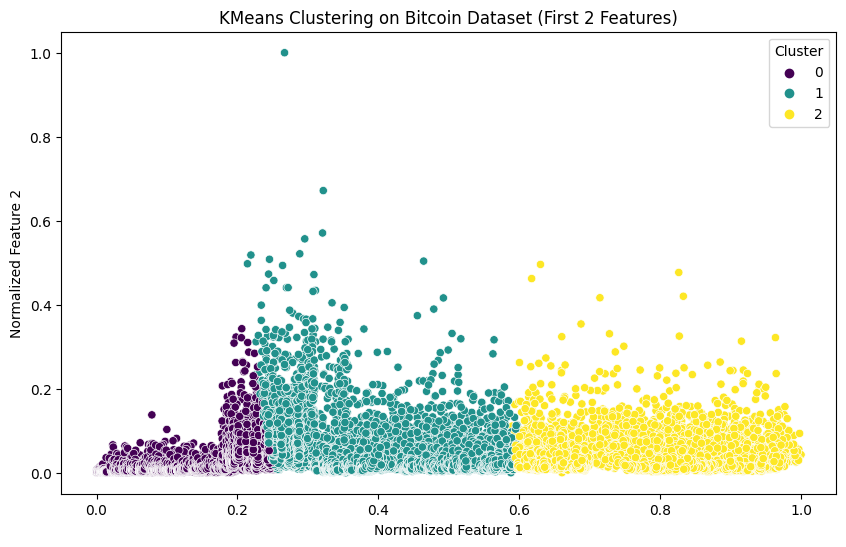

Cluster Counts:
Cluster
0    29278
1    18190
2    10986
Name: count, dtype: int64


In [21]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_scaled)

# Küme etiketlerinin atanması
data_scaled['Cluster'] = kmeans.labels_

#Küme merkezlerinin yazdırılması
print("Küme Merkezleri (Normalize):")
print(kmeans.cluster_centers_)

#Küme dağılımlarının görselleştirilmesi (ilk iki özellik üzerinden)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_scaled.iloc[2:, 3], y=data_scaled.iloc[4:, 5], hue=data_scaled['Cluster'], palette='viridis')
plt.title("Bitcoin Datasetinde KMeans kümesi  (İlk 2 Feature)")
plt.xlabel('Normalize Feature 1')
plt.ylabel('Normalize Feature 2')
plt.show()

# Her kümedeki veri sayısını gösterme
print("Küme Sayacı:")
print(data_scaled['Cluster'].value_counts())

In [22]:
X = data_scaled.drop(columns=['Close'])
y = data_scaled['Close']

#Linear Regression modelini tanımlama
model = LinearRegression()

#Cross-validation için 5 katlı KFold ayarı (5-fold cross-validation)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#Cross-validation'ı MSE (Mean Squared Error) ile değerlendirme
mse_scorer = make_scorer(mean_squared_error)

#Cross-validation sonuçlarının hesaplanması
cv_results = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)

#Sonuçların yazdırılması (her fold için MSE ve ortalama MSE)
print(f"Cross-Validation MSE Scores for each fold: {cv_results}")
print(f"Average MSE across all folds: {np.mean(cv_results)}")


Cross-Validation MSE Scores for each fold: [1.99456893e-06 2.11938457e-06 1.91885141e-06 2.14152690e-06
 1.85547307e-06]
Average MSE across all folds: 2.0059609749001987e-06
